In [1]:
%pylab inline --no-import-all
import numpy as np
import scipy as sp
import pylab as pl
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


"""     Inputs

   S_0 - Current Asset price
   K  - Strike price of option
   r  - risk free interest rate (lending)
   R  - Borrowing interest rate
   sigma - Volatility of underltying stock
   T  - Maturity of option
   m  - Number of timesteps to take
   N  - Number of paths to simulate.
   d  - polynomial fit degree
   
"""

Populating the interactive namespace from numpy and matplotlib


C:\Users\Majdi\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


'     Inputs\n\n   S_0 - Current Asset price\n   K  - Strike price of option\n   r  - risk free interest rate (lending)\n   R  - Borrowing interest rate\n   sigma - Volatility of underltying stock\n   T  - Maturity of option\n   m  - Number of timesteps to take\n   N  - Number of paths to simulate.\n   d  - polynomial fit degree\n   \n'

In [4]:
"Function creating N paths for the Black-Scholes formula"


def stocks_paths(S_0,r,sigma,delta_t,N,m,mu):     
    S = np.zeros((m + 1, N))
    delta_B = np.zeros((m + 1, N))
    S[0] = S_0
    for t in range(1,m + 1):
        X=np.random.standard_normal(size=N)
        S[t]=S[t-1]*np.exp((mu-sigma*sigma/2)*delta_t+sigma*np.sqrt(delta_t)*X)
        delta_B[t] = np.sqrt(delta_t) * X
    S_delta_B={'Stocks' : S,'delta_B': delta_B}
    return S_delta_B      

In [21]:
                                            "Pricing of the American Option"



def pricing_option(mu,R,K1,K2,r,sigma,N,m,S_0,T, RF_n_estimators, RF_max_leaf_nodes):
  
    "Time-step"
    dt=T/m
    "Discount factor"
    df=1/(1+r*dt)
    "theta"
    theta=(mu-r)/sigma
    "Creation of a stock path matrix"
    S_delta_B=stocks_paths(S_0,r,sigma,dt,N,m,mu)
    S=S_delta_B['Stocks']
    delta_B=S_delta_B['delta_B']
    
  
    "price of the option at time T = Initialization for a call" 
    Y=np.maximum(S[-1]-K1,0)-2*np.maximum(S[-1]-K2,0)
     
   
    "Iteration over the paths"
    for t in range (m-2,0,-1): 
        Z=np.zeros(N)
        X=S[t]
        X=X[:,None]
        
        
        "Random Forest algorithm uses the j'th time of the Stock and the (j+1)'th time of Option Price to fit "
        rf=RandomForestRegressor(n_estimators=RF_n_estimators,
                                 max_leaf_nodes= RF_max_leaf_nodes,
                                 oob_score=False, 
                                 n_jobs=-1)
        
        
        rf.fit(X,Y*delta_B[t])
        Z=rf.predict(X)*(1/dt)
        
        rf.fit(X,Y)
        J=rf.predict(X)
        Y=J-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
        
    Y_opt= df * sum(Y)/N
    return (Y_opt)

In [22]:
"""Pricing with BS formula"""

def black_scholes(K,r,sigma, S_0,T): 
    d1=1/(sigma*np.sqrt(T))*(np.log(S_0/K)+(r+0.5*sigma*sigma)*T)
    d2=d1-sigma*np.sqrt(T)
    dscnt=np.exp(-r*T)
    Call=-norm.cdf(d2)*K*dscnt+norm.cdf(d1)*S_0
    return (Call)

In [23]:
                                """Pricing by Random Forest"""

start = time.time()

  
    
"Parameters"
T=0.25
m=12
K1=95.
K2=105.
S_0=100.
r=0.01
sigma=0.2
N=10000
mu=0.05
R=0.06
RF_n_estimators = 10
RF_max_leaf_nodes = 2

"We price"    

price_BSDE=pricing_option(mu,R,K1,K2,r,sigma,N,m,S_0,T, RF_n_estimators,RF_max_leaf_nodes)
#price_BScholes=black_scholes(K,R,sigma, S_0,T)
print ("price ", price_BSDE) 
#print ("price BScholes ", price_BScholes)

end = time.time()
print(end - start,"s") 

price  2.6988971733
5.387592077255249 s


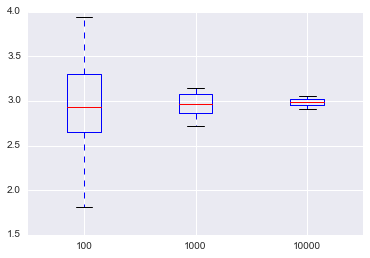

'We price'

In [49]:
                                """Simulations : m varying"""

    

"Parameters"
T=0.25
m=12
K1=95
K2=105
S_0=100
r=0.01
sigma=0.2
mu=0.05
R=0.06
RF_n_estimators = 100
d=5


N_range=[100,1000,10000]
Prices=[]

for N in N_range:
    Prices_int=np.zeros(15)
    for i in range (15): 
        Prices_int[i]=pricing_option(mu,R,K1,K2,r,sigma,N,m,S_0,T,d, RF_n_estimators)
        
    Prices.append(Prices_int)
  

    
df = pd.DataFrame(np.transpose(Prices), columns=['100','1000','10000'])

df.plot(kind='box')
plt.show()

"We price"    

